In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
from math import sqrt


In [3]:

# Load
df_projects = pd.read_csv('mining_projects.csv', sep=';')

df_factory =  pd.read_csv('factory.csv', sep=';')

print(df_projects.head())


print(df_projects.dtypes)

   Project No.  Deposit No.                    Company Name  \
0            1          1.0               Lynas Rare Earths   
1            2          2.0                    MP Materials   
2            3          3.0         Iluka Resources Limited   
3            4          4.0                             NaN   
4            5          5.0  Australian Strategic Materials   

              Project Name                                       Location  \
0               Mount Weld                          Mount Weld, Australia   
1            Mountain Pass     Central Mojave Desert, California, America   
2                  Eneabba          Eneabba, Western Australia, Australia   
3  WIM100 (Wimmera、Mallee)  Wimmera & Mallee,Western Australia, Australia   
4           Dubbo (Toongi)              Dubbo, New South Wales, Australia   

       Continent  \
0      Australia   
1  North America   
2      Australia   
3      Australia   
4      Australia   

   Status (2022), 1: Exploration/ Def

In [5]:
df_factory.head()

,No.,Company,Project,Location,Status (2022) 1: Crushing roughing: Operate mineral concentration; 3: mixed REO; 4:Operate seprated REO; 5 Metal; T Trial production; P Pre-feasibility study; PT Project terminated,Capacity,Yield,Upstream,Downstream,Status Ref.,Capacity Ref.,Yield Ref.,Upstream Ref.,Downstream Ref.
0,1,Lynas Rare Earths,Mount Weld Plant,"Mount Weld, Australia",2,66kt/y concentration (contain 26500t REO),NaN,Mount Weld,Kuantan plant,NaN,https://lynasrareearths.com/about-us/locations...,NaN,NaN,NaN
1,2,NaN,Kuantan Plant,Kuantan,4,~20kt,"15761t/y (REO, 2021)",Kuantan plant,"Japan, Europe, China, and North America",NaN,NaN,https://lynasrareearths.com/wp-content/uploads...,NaN,NaN
2,3,NaN,Kalgoorlie Plant,"Kalgoorlie,Australia",3(2023),NaN,-,NaN,-,NaN,NaN,NaN,NaN,NaN
3,4,NaN,HREE separate Plant,"Hondo, Texas, USA",NaN,"5000t/y (REO, containing 1250t/PrNd)",NaN,Kalgoorlie plant,NaN,NaN,https://news.cnpowder.com.cn/58843.html; https...,NaN,NaN,NaN
4,5,MP Materials,Mountain Pass Plant,"Central Mojave Desert, California, USA",2,NaN,"42413t/y（2021, REO）",Mountain Pass,China,NaN,NaN,MP Materials Reports First Quarter 2021 Result...,NaN,https://www.defensenews.com/opinion/commentary...


EDA
-----------------------------------------------------------------------------

In [7]:
print('Shape of factories:', df_factory.shape)
print('Shape of projects:', df_projects.shape)

Shape of factories: (67, 14)
Shape of projects: (146, 31)


In [8]:
# Create copies of the dataframes to play with
factories = df_factory
projects = df_projects

Cleaning the factories data. 
- Company is not defined for each, but we know that the projects are listed by company. Fill in the missing data.
- Remove some columns that arent interesting to us (number, references to measurements).
- Rename Status column. We will take note of the status value mappings
    - 1: Crushing roughing 
    - 2: Operate mineral concentration
    - 3: mixed REO
    - 4: Operate seprated REO
    - 5: Metal
    - T: Trial production
    - P: Pre-feasibility study
    - PT: Project terminated

In [9]:
factories['Company'] = factories['Company'].fillna(method='ffill')
factories = factories.drop(columns=['No.','Status Ref.','Capacity Ref.','Yield Ref.','Upstream Ref.','Downstream Ref.'])
factories.rename(columns={factories.columns[3]: "Status"}, inplace=True)
factories.head()

,Company,Project,Location,Status,Capacity,Yield,Upstream,Downstream
0,Lynas Rare Earths,Mount Weld Plant,"Mount Weld, Australia",2,66kt/y concentration (contain 26500t REO),NaN,Mount Weld,Kuantan plant
1,Lynas Rare Earths,Kuantan Plant,Kuantan,4,~20kt,"15761t/y (REO, 2021)",Kuantan plant,"Japan, Europe, China, and North America"
2,Lynas Rare Earths,Kalgoorlie Plant,"Kalgoorlie,Australia",3(2023),NaN,-,NaN,-
3,Lynas Rare Earths,HREE separate Plant,"Hondo, Texas, USA",NaN,"5000t/y (REO, containing 1250t/PrNd)",NaN,Kalgoorlie plant,NaN
4,MP Materials,Mountain Pass Plant,"Central Mojave Desert, California, USA",2,NaN,"42413t/y（2021, REO）",Mountain Pass,China


Cleaning the Mining Projects Data
- As with the projects data, we will fill in the missing company data.
- Also as with the projects data, we will remove the refernece columns from the dataset
- Remove the status column. We take note of the mappings
    - 1: Exploration/ Define resource
    - 2: Feasibility/ Pre-feasibility
    - 3: Construction
    - 4: Production
    - S: Suspending mining
    - T: Test of Metallurgical
    - D: Development licence
    - N: Not Use
    
- We rename the columns in the Projects data to match (where possible) the factories data. This might help later

In [10]:
projects['Company Name'] = projects['Company Name'].fillna(method='ffill')
projects = projects.drop(columns=['Project No.', 'Deposit No.','REE pattern Ref.','Project and status Ref.','Deposit type Ref.','Resource and grade Ref.'])
projects.rename(columns={projects.columns[4]: "Status"}, inplace=True)
projects.rename(columns={projects.columns[0]: "Company", projects.columns[1]: "Project"}, inplace=True)
projects.head()

,Company,Project,Location,Continent,Status,Deposit type,"Resource (*10^4 t, REO, Total)",Grade (wt. %),La2O3,Ce2O3,...,Tb4O7,Dy2O3,Ho2O3,Er2O3,Tm2O3,Yb2O3,Lu2O3,Y2O3,HREE percentage,Unnamed: 30
0,Lynas Rare Earths,Mount Weld,"Mount Weld, Australia",Australia,4,Carbonatite,300,"5,4","24,11212582","45,66210046",...,"0,139523085","0,481988838","0,063419584","0,139523085","0,012683917","0,063419584",0,"1,775748351","3,970065956",NaN
1,MP Materials,Mountain Pass,"Central Mojave Desert, California, America",North America,4,Carbonatite,"418,3","8,9","33,20134024","49,10143162",...,"0,06091989","0,045689918","0,015229973","0,015229973","0,015229973","0,015229973","0,015229973","0,106609808","0,487359123",NaN
2,Iluka Resources Limited,Eneabba,"Eneabba, Western Australia, Australia",Australia,4,Placer,"7,29","0,09","23,3358923","45,80451814",...,0,"0,909987376","0,112744641","0,478281399","0,067454059","0,439415013","0,052035988","6,422911253","10,08020609",NaN
3,Iluka Resources Limited,WIM100 (Wimmera、Mallee),"Wimmera & Mallee,Western Australia, Australia",Australia,2,Placer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Australian Strategic Materials,Dubbo (Toongi),"Dubbo, New South Wales, Australia",Australia,4(2022),Alkaline rock,"55,63","0,74","19,57255343","36,89538808",...,"0,337457818","2,024746907","0,337457818","1,124859393","0,112485939","1,012373453","0,112485939","15,86051744","23,05961755",NaN


Further exploration
-----------------------------------------------------------------------------

<Axes: >

/Users/joshcyphers/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  func(*args, **kwargs)
/Users/joshcyphers/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  func(*args, **kwargs)
/Users/joshcyphers/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/joshcyphers/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


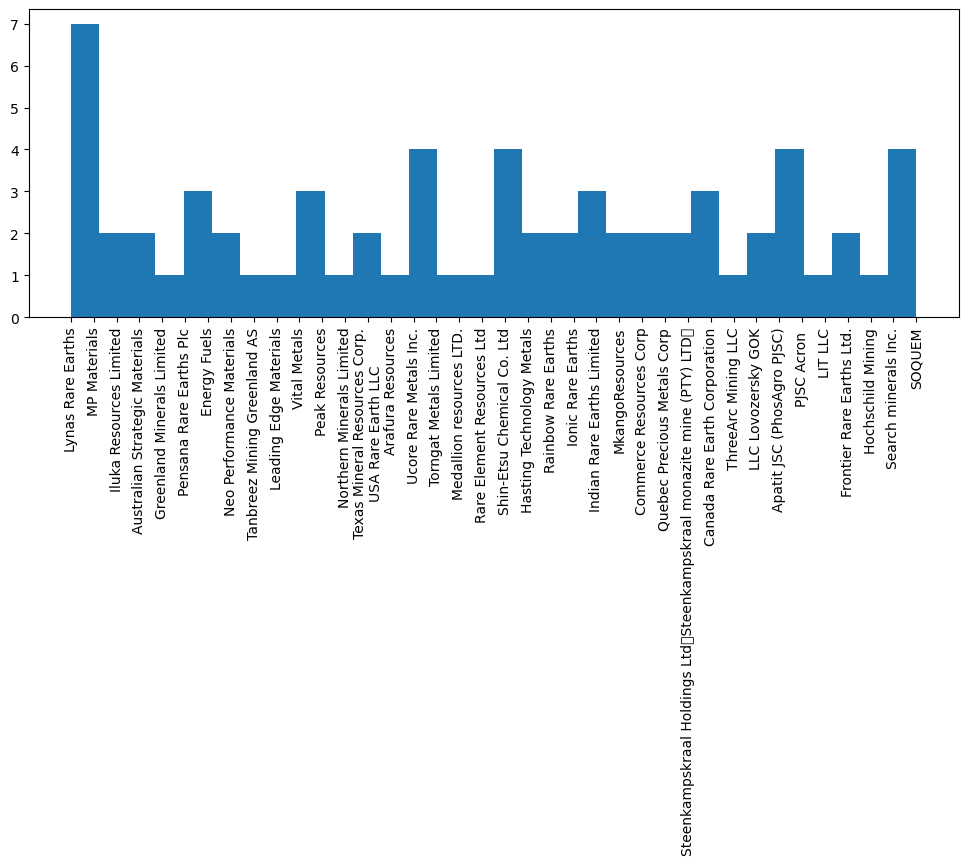

In [11]:
factories['Company'].hist(xrot=90, bins=30, grid=False, figsize=(12,4))

<Axes: >

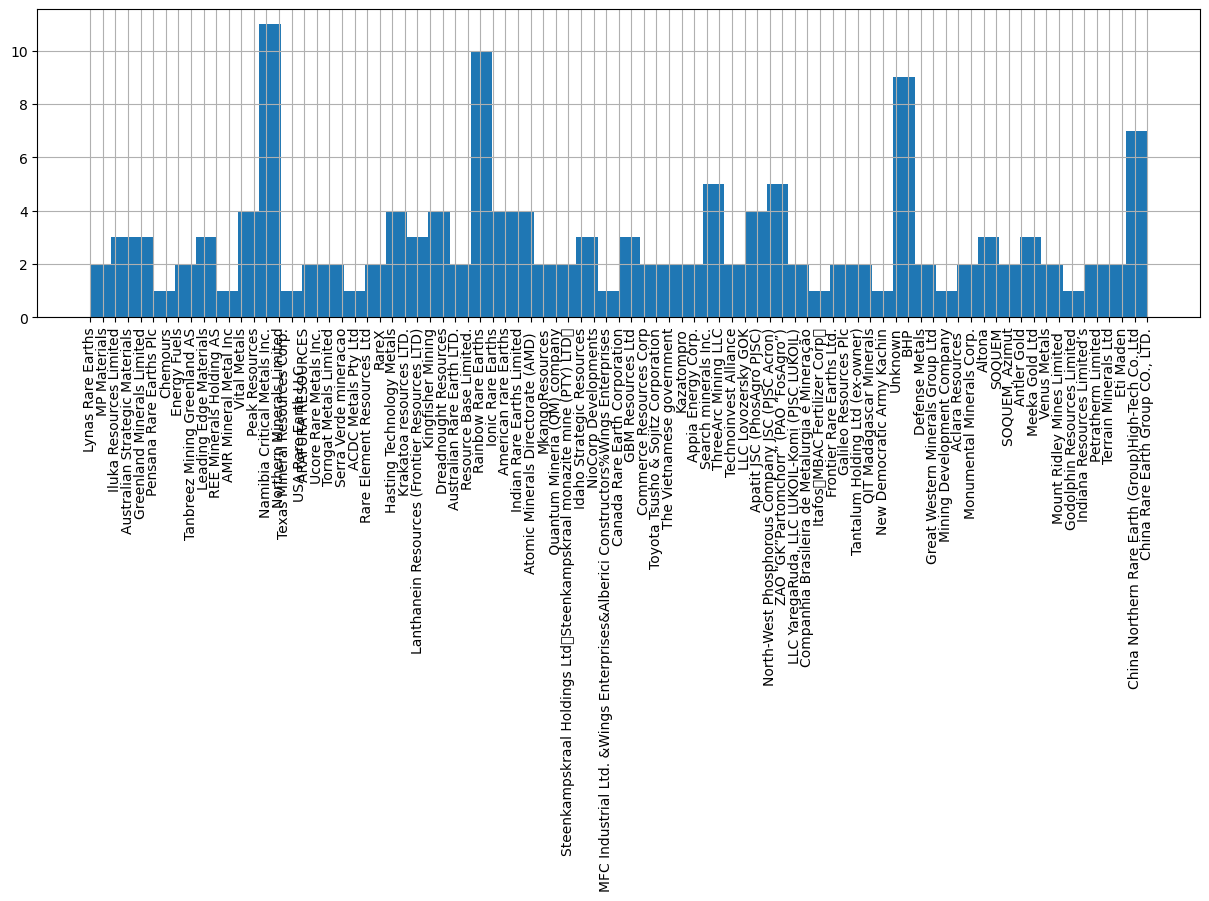

In [12]:
projects['Company'].hist(xrot=90, bins=50, figsize=(15,4))

<Axes: >

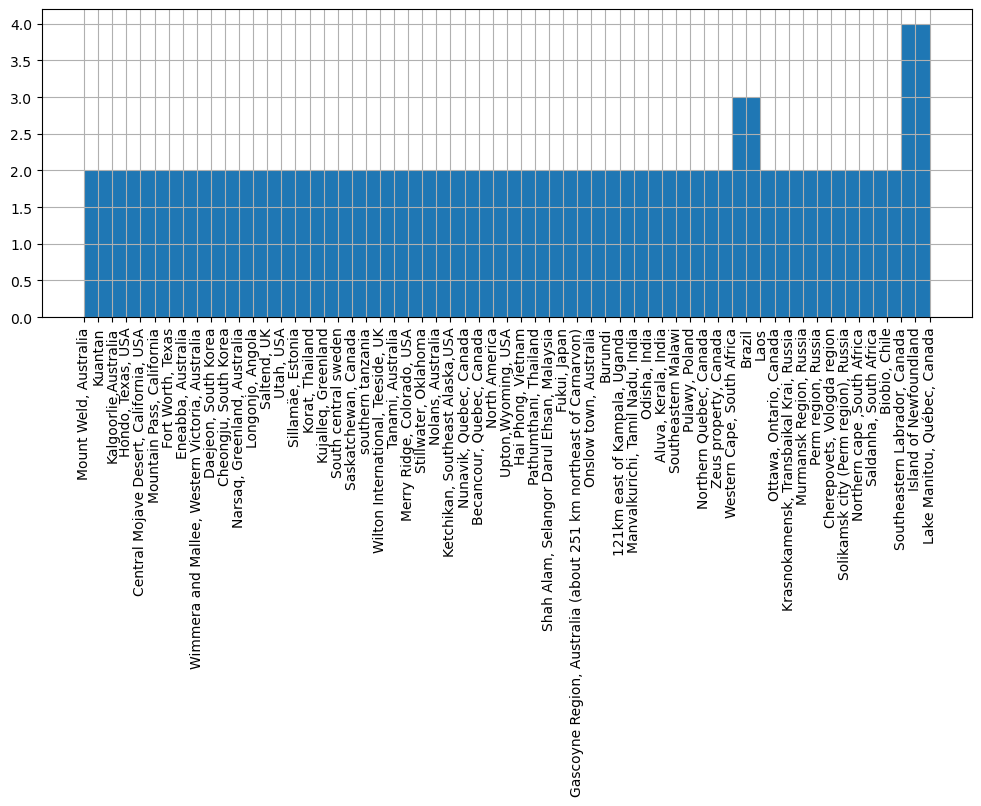

In [13]:
factories['Location'].hist(xrot=90, bins=30, grid=True, figsize=(12,4))

<Axes: >

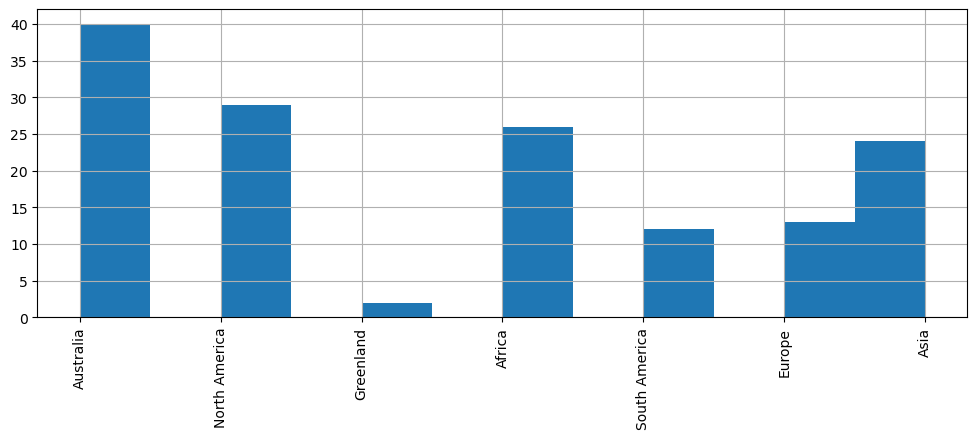

In [14]:
projects['Continent'].hist(xrot=90, bins=12, grid=True, figsize=(12,4))

In [15]:
factories['Company'].value_counts()

Company
Lynas Rare Earths                                                        4
Shin-Etsu Chemical Co. Ltd                                               4
Search minerals Inc.                                                     3
Apatit JSC (PhosAgro PJSC)                                               3
Canada Rare Earth Corporation                                            3
Indian Rare Earths Limited                                               3
MP Materials                                                             3
Iluka Resources Limited                                                  2
Ucore Rare Metals Inc.                                                   2
Frontier Rare Earths Ltd.                                                2
LLC Lovozersky GOK                                                       2
Commerce Resources Corp                                                  2
MkangoResources                                                          2
Australian Strate

In [16]:
factories['Project'].value_counts()

Project
Mount Weld Plant                                         1
Laos Rare Earth Refinery                                 1
Yangibana plant                                          1
Onslow hydrometallurgical Rare Earth processing plant    1
Gakara plant                                             1
                                                        ..
Strange Lake plant                                       1
Becancour Rare Earth Separation Plant                    1
Refining of PrNd oxide from monazite                     1
Wyoming refining Plant                                   1
Kwyjibo concentrator factore                             1
Name: count, Length: 67, dtype: int64

In [17]:
projects['Company'].value_counts()

Company
Rainbow Rare Earths                     10
Northern Minerals Limited                9
Unknown                                  7
China Rare Earth Group CO., LTD.         6
ZAO “GK”Partomchorr” (PAO “FosAgro”)     4
                                        ..
AMR Mineral Metal Inc                    1
REE Minerals Holding AS                  1
Technoinvest Alliance                    1
LLC Lovozersky GOK                       1
Lynas Rare Earths                        1
Name: count, Length: 85, dtype: int64

In [18]:
projects['Project'].value_counts()

Project
Mangaroon                        2
Mt Clere                         2
Mount Weld                       1
Khibiny (Yuksporskoe/Yukspor)    1
Khibiny (Apatitovy Cirque)       1
                                ..
Gascoyne (Edmund & Lyons)        1
Rand                             1
Brockman                         1
Yangibana (Gifford Creek)        1
South China seven proveince      1
Name: count, Length: 144, dtype: int64

In [19]:
continents = list(projects["Continent"].value_counts().nlargest(7).index)
projects['HREE percentage'] = projects['HREE percentage'].str.replace(',', '').astype(float)

df_deposit_pivot = pd.pivot_table(projects,index=["Continent", "Deposit type"],
               values=["HREE percentage"])
df_deposit_pivot

HREE percentage
Continent     Deposit type                                                       
Africa        Carbonatite                                            2.415983e+09
              Carbonatite (Tailings)                                 5.871301e+08
              Hydrothermal/IOCG (Monazite veins)                     7.914286e+09
              Ionic Clay                                             1.156500e+03
              Placer                                                 2.940000e+02
Asia          Alkaline                                               1.460000e+02
              Alkaline granite                                       9.728000e+03
              Carbonatite                                            8.885331e+08
              Clays                                                  5.109000e+03
              Placer                                                 2.898551e+09
Australia     Alkaline rock                                          3.168400e+09
              Carbonatite                                            4.855534e+09
              Hydrothermal/IOCG                                      5.654860e+09
              Hydrothermal/IOCG (Tailings)                           1.475410e+09
              Ionic Clay                                             3.130000e+02
              Placer                                                 1.008021e+09
Europe        Alkaline rock                                          2.495770e+09
              Carbonatite                                            3.016723e+09
              Hydrothermal/IOCG                                      3.371336e+09
Greenland     Alkaline rock                                          2.139951e+09
North America Alkaline granite                                       3.986928e+09
              Alkaline rock                                          1.017145e+09
              Alkaline/Alkaline granite                              3.731844e+09
              Carbonatite                                            1.103486e+09
              Hydrothermal/IOCG                                      1.582015e+09
              Metamorphic rocks (quartz feldspar gneiss), sed...     1.666667e+09
              Paleo-sedimentary formation                            7.291667e+09
              Rhyolite                                               7.419355e+09
South America Alkaline granite                                       7.486000e+03
              Carbonatite                                            7.762995e+08
              Ionic Clay                                             1.163522e+09

In [20]:
locations = projects['Location'].value_counts().to_dict().items()

In [21]:
projects_popular_locations = projects[projects['Location'].isin([key for key, val in locations if val > 2])]
projects_popular_locations.head()

,Company,Project,Location,Continent,Status,Deposit type,"Resource (*10^4 t, REO, Total)",Grade (wt. %),La2O3,Ce2O3,...,Tb4O7,Dy2O3,Ho2O3,Er2O3,Tm2O3,Yb2O3,Lu2O3,Y2O3,HREE percentage,Unnamed: 30
21,Northern Minerals Limited,Browns Range (Wolverine),"Tanami, Australia",Australia,1,Hydrothermal/IOCG,6,"0,67","2,435723951","5,953991881",...,"1,217861976","8,389715832","1,894451962","5,277401894","0,811907984","4,330175913","0,541271989","56,29228687",8.443843e+09,NaN
22,Northern Minerals Limited,Browns Range (Gambit),"Tanami, Australia",Australia,1,Hydrothermal/IOCG,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,Northern Minerals Limited,Browns Range (Gambit West),"Tanami, Australia",Australia,1,Hydrothermal/IOCG,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Northern Minerals Limited,Browns Range (Area 5),"Tanami, Australia",Australia,1,Hydrothermal/IOCG,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Northern Minerals Limited,Browns Range (Cyclops),"Tanami, Australia",Australia,1,Hydrothermal/IOCG,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
loc_deposit_pivot = pd.pivot_table(projects_popular_locations,index=["Location", "Deposit type"],
               values=["HREE percentage"])
loc_deposit_pivot.head()

HREE percentage
Location                      Deposit type                  
Bujumbura, Burundi            Carbonatite       2.117850e+09
China                         Alkaline          1.460000e+02
                              Carbonatite       1.599359e+09
                              Clays             5.109000e+03
Southeastern Labrador, Canada Alkaline rock     2.041420e+09

Failed attempt to predict the status of the project
-----------------------------------------------------------------------------

In [ ]:
# Data preprocessing


# Convert categorical columns to numerical using LabelEncoder
label_encoder = LabelEncoder()
categorical_cols = ['Company Name', 'Location', 'Continent', 'Deposit type', 'Project Name']
for col in categorical_cols:
    df_projects[col] = label_encoder.fit_transform(df_projects[col])

#df_projects = df_projects.rename(columns={'Status (2022), 1: Exploration/ Define resource; 2: Feasibility/ Pre-feasibility; 3: Construction; 4: Production; S: Suspending mining; T: Test of Metallurgical; D: Development licence; N: Not Use': 'Status'}, inplace=True))

col_list = df_projects.columns.tolist()

col_list[6] = 'Status'

df_projects.columns = col_list


df_projects['status_cleaned'] = np.nan
df_projects['year'] = np.nan

for idx, row in df_projects.iterrows():
    status = row['Status']
    
    if pd.isna(status):
        continue

    
    if '(' in status and ')' in status:
        status_splitted = status.split('(')
        df_projects.at[idx, 'status_cleaned'] = status_splitted[0].strip()
        df_projects.at[idx, 'year'] = status_splitted[1].replace(')', '').strip()
    else:
        df_projects.at[idx, 'status_cleaned'] = status.strip()


df_projects['year'] = pd.to_numeric(df_projects['year'], errors='coerce')


df_projects.drop(['Status'], axis=1, inplace=True)

# Convert string to numeric
df_projects['HREE percentage'] = pd.to_numeric(df_projects['HREE percentage'].str.replace(',', '.'), errors='coerce')

# Fill NaNs in 'year' 
df_projects['year'] = df_projects['year'].fillna(-1)

# Fill NaNs in 'HREE percentage' 
mean_value = df_projects['HREE percentage'].mean()
df_projects['HREE percentage'] = df_projects['HREE percentage'].fillna(mean_value)

cols_to_drop = ['REE pattern Ref.', 'Project and status Ref.', 'Deposit type Ref.', 'Resource and grade Ref.', 'Unnamed: 30']
df_projects.drop(cols_to_drop, axis=1, inplace=True)

status_splits = df_projects['status_cleaned'].str.split(',').apply(pd.Series, 1).stack()
status_splits.index = status_splits.index.droplevel(-1)
status_splits.name = 'status_cleaned_new'
df_projects = df_projects.join(status_splits)
df_projects['status_cleaned_new'] = df_projects['status_cleaned_new'].str.strip()  


status_mapping = {
    '1': 'Early Stage',
    '2': 'Middle Stage',
    '3': 'Late Stage',
    '4': 'Production',
    'T': 'Testing',
    'D': 'Development',
    'S': 'Suspending',
    'C': 'Construction',
    'N': 'Not Use'
    # Add mappings for other statuses as needed
}
df_projects['status_simplified'] = df_projects['status_cleaned_new'].map(status_mapping)

df_projects.loc[df_projects['status_cleaned_new'] == '1&T', 'status_cleaned_new'] = 'Early Stage' # or 'Test of Metallurgical', as appropriate
df_projects.loc[df_projects['status_cleaned_new'] == '2021', 'status_cleaned_new'] = np.nan # Treat '2021' as NaN
df_projects.loc[df_projects['status_cleaned_new'] == 'N', 'status_cleaned_new'] = np.nan # Treat 'N' as NaN


In [ ]:

unique_values = df_projects['status_cleaned_new'].unique()
print(unique_values)

In [ ]:
# Define input features and target variable
input_features = ['Deposit No.', 'Company Name', 'Location', 'Continent', 'Deposit type', 'HREE percentage', 'year']
target_variable = 'status_cleaned'

# Prepare data for train/test split
X = df_projects[input_features]
y = df_projects[target_variable]

# Normalize X
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Replace NaNs
#X_train = np.nan_to_num(0)
#X_test = np.nan_to_num(0)

#y_train = np.nan_to_num(0)
#y_test = np.nan_to_num(0)

print(X_train.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

Predicting REE amounts in a project based on Location, Continent, and Deposit type
-----------------------------------------------


In [ ]:
elements = ['La2O3', 'Ce2O3', 'Pr6O11', 'Nd2O3', 'Sm2O3', 'Eu2O3', 'Gd2O3', 'Tb4O7', 'Dy2O3', 'Ho2O3', 'Er2O3', 'Tm2O3', 'Yb2O3', 'Lu2O3', 'Y2O3']

for element in elements:
    df_projects[element] = df_projects[element].replace('-', np.nan)
    df_projects[element] = df_projects[element].str.replace(',', '.').astype(float)

df_projects = df_projects.dropna(subset=elements)

input_features = ['Location', 'Continent', 'Deposit type']
target_variables = elements

X = df_projects[input_features]
y = df_projects[target_variables]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=[len(input_features)]),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(len(target_variables))  
])

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=10, validation_split=0.2)

predictions = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Overall Test RMSE: {rmse}')

y_pred_df = pd.DataFrame(predictions, columns=target_variables)

rmse_values = {}

for element in target_variables:
    mse = mean_squared_error(y_test[element], y_pred_df[element])
    rmse_values[element] = sqrt(mse)

for element, rmse in rmse_values.items():
    print(f'RMSE for {element}: {rmse}')


Don't run the below models
----------------------------------------------------

In [ ]:

elements = ['La2O3', 'Ce2O3', 'Pr6O11', 'Nd2O3', 'Sm2O3', 'Eu2O3', 'Gd2O3', 'Tb4O7', 'Dy2O3', 'Ho2O3', 'Er2O3', 'Tm2O3', 'Yb2O3', 'Lu2O3', 'Y2O3']

for element in elements:
    df_projects[element] = df_projects[element].replace('-', np.nan)
    df_projects[element] = df_projects[element].str.replace(',', '.').astype(float)


df_projects = df_projects.dropna(subset=elements)

input_features = ['Location', 'Continent', 'Deposit type']
target_variables = elements

X = df_projects[input_features]
y = df_projects[target_variables]


scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=[len(input_features)]),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(len(target_variables))  
])


model.compile(loss='mean_squared_error', optimizer='adam')


model.fit(X_train, y_train, epochs=10, validation_split=0.2)


predictions = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {rmse}')


In [ ]:

elements = ['La2O3', 'Ce2O3', 'Pr6O11', 'Nd2O3', 'Sm2O3', 'Eu2O3', 'Gd2O3', 'Tb4O7', 'Dy2O3', 'Ho2O3', 'Er2O3', 'Tm2O3', 'Yb2O3', 'Lu2O3', 'Y2O3']

for element in elements:
    df_projects[element] = df_projects[element].replace('-', np.nan)
    df_projects[element] = df_projects[element].str.replace(',', '.').astype(float)

df_projects = df_projects.dropna(subset=elements)

input_features = ['Location', 'Continent', 'Deposit type']
target_variables = elements

X = df_projects[input_features]
y = df_projects[target_variables]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=[len(input_features)]),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(len(target_variables))
])

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=10, validation_split=0.2)

y_pred = model.predict(X_test)


y_pred_df = pd.DataFrame(y_pred, columns=target_variables)


rmse_values = {}


for element in target_variables:
    mse = mean_squared_error(y_test[element], y_pred_df[element])
    rmse_values[element] = sqrt(mse)

for element, rmse in rmse_values.items():
    print(f'RMSE for {element}: {rmse}')
